In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm

In [2]:
import platform
#运行环境
print(platform.uname())

#numpy版本
print("numpy version:",np.__version__)
#pandas版本
print("pandas version:",pd.__version__)
#seaborn版本
print("seaborn version:",sns.__version__)
#matplotlib版本
print("matplotlib version:",matplotlib.__version__)
#sklearn版本
print("sklearn version:",sklearn.__version__)
#statsmodels版本
print("sklearn version:",sm.__version__)

uname_result(system='Windows', node='DESKTOP-C052PDI', release='10', version='10.0.19044', machine='AMD64')
numpy version: 1.22.4
pandas version: 1.4.2
seaborn version: 0.11.2
matplotlib version: 3.5.2
sklearn version: 1.1.1
sklearn version: 0.13.2


In [3]:
#读取数据
df_2011 = pd.read_csv('gt_2011.csv')
df_2012 = pd.read_csv('gt_2012.csv')
df_2013 = pd.read_csv('gt_2013.csv')
df_2014 = pd.read_csv('gt_2014.csv')
df_2015 = pd.read_csv('gt_2015.csv')

#前3年的数据用作训练集、后两年的数据用作验证集
df = pd.concat([df_2011,df_2012,df_2013],ignore_index=True)
df_validation = pd.concat([df_2014,df_2015],ignore_index=True)

In [4]:
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028


In [5]:
df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,22191.000000,22191.000000,22191.000000,22191.000000,22191.000000,22191.000000,22191.000000,22191.000000,22191.000000,22191.000000,22191.000000
mean,17.712247,1012.812607,79.555224,4.037750,25.317873,1083.080280,545.520170,133.537393,12.060208,2.214390,68.776529
std,7.352789,6.396588,13.915018,0.810223,4.234147,16.840765,7.708708,16.026107,1.114265,2.295746,11.036231
min,0.289850,985.850000,27.504000,2.087400,17.878000,1000.800000,512.450000,100.170000,9.875400,0.000388,27.765000
25%,11.664500,1008.800000,70.294500,3.449850,22.736000,1074.600000,542.600000,124.260000,11.395000,0.995375,61.548000
50%,17.739000,1012.400000,82.781000,4.068800,24.989000,1088.100000,549.900000,133.770000,12.001000,1.524200,67.096000
75%,23.657000,1016.700000,90.532000,4.451400,26.839000,1095.300000,550.050000,138.645000,12.443500,2.542400,74.572000
max,34.929000,1034.200000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,44.103000,119.910000


# 1.预处理

## 1.1. 数据中心化和标准化

In [6]:
z_scaler = preprocessing.StandardScaler()
df_scaled = z_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df.columns

## 1.2. 数据类型及分布状况

In [7]:
df_scaled.dtypes

AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

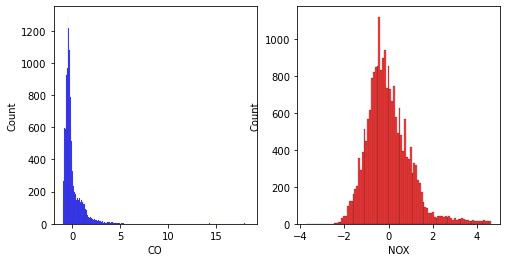

In [8]:
#先观察两个响应变量的分布状况
fig, axs = plt.subplots(1, 2, figsize=(8,4))

plt.subplot(121)
#sns.histplot(df["CO"],color='b',ax = axs[0])
sns.histplot(df_scaled["CO"],color='b',ax = axs[0])
plt.subplot(122)
#sns.histplot(df["NOX"],color='r',ax = axs[1])
sns.histplot(df_scaled["NOX"],color='r',ax = axs[1])
plt.savefig("./y_hist.jpg")

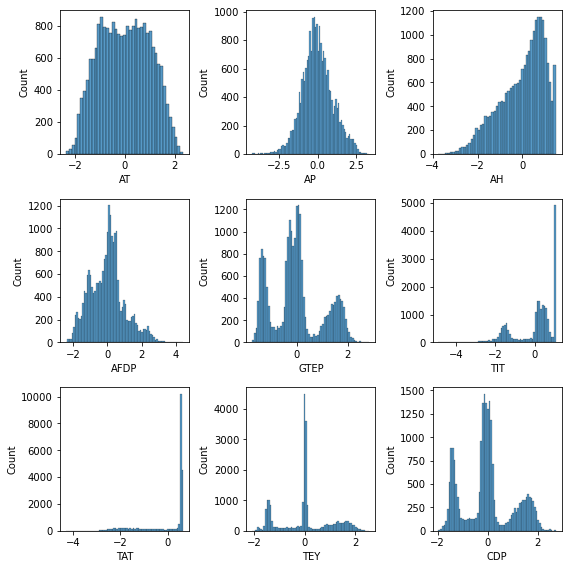

In [9]:
#观察协变量的分布
#直方图
fig, axs = plt.subplots(3,3,figsize=(8,8))
sns.histplot(df_scaled['AT'], ax=axs[0,0])
sns.histplot(df_scaled['AP'], ax=axs[0,1])
sns.histplot(df_scaled['AH'], ax=axs[0,2])
sns.histplot(df_scaled['AFDP'], ax=axs[1,0])
sns.histplot(df_scaled['GTEP'], ax=axs[1,1])
sns.histplot(df_scaled['TIT'], ax=axs[1,2])
sns.histplot(df_scaled['TAT'], ax=axs[2,0])
sns.histplot(df_scaled['TEY'], ax=axs[2,1])
sns.histplot(df_scaled['CDP'], ax=axs[2,2])
plt.tight_layout()
plt.savefig("./x_hist.jpg")
plt.show()

## 1.3.缺省值

In [10]:
#找存在缺省值的列
df_scaled.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

## 1.4.观察各指标的相关系数，画出热力图

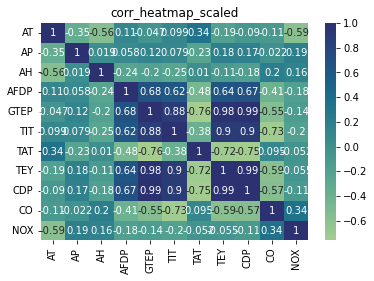

In [11]:
df_scaled_corr=df_scaled.corr()
sns.heatmap(df_scaled_corr,annot=True,cmap="crest")
plt.title("corr_heatmap_scaled")
plt.savefig("./corr_heatmap_scaled.png")

从以上热力图可以看出各指标的相关性很高，尤其是机器参数部分，这意味着数据存在很强的多重共线性。

接下来选择采用主成分分析的方法对数据进行降维

## 1.5.主成分分析法降维，减弱多重共线性

In [12]:
#PCA
#只对机器参数做PCA，因为环境参数看起来相关性不高
#选择前3个主成分使得解释比率达到95%以上

X = df_scaled[['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP']]
Y = df_scaled[["CO","NOX"]]

operational_features_train = X[['AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP']]
pca3 = PCA(n_components=3, random_state=0)
pca = pca3.fit_transform(operational_features_train)
pca = pd.DataFrame(pca, columns=['PCA1', 'PCA2', 'PCA3'])
#前三个主成分的解释比例
pca3.explained_variance_ratio_
#pca3.explained_variance_ratio_.sum()

array([0.80733477, 0.10793863, 0.08064769])

In [13]:
pca

,PCA1,PCA2,PCA3
0,-0.487851,-0.430135,-0.571701
1,-0.507462,-0.449116,-0.576397
2,-0.422285,-0.478584,-0.600141
3,-0.453642,-0.477012,-0.591290
4,-0.503315,-0.439866,-0.565988
...,...,...,...
22186,3.996663,1.107329,-0.886034
22187,3.961056,1.062198,-0.931324
22188,4.072560,1.156988,-0.901431
22189,3.934008,1.051559,-0.947338


## 1.6.观察处理后的数据的相关性

In [14]:
#将处理后的数据合并成一个dataframe
df_preprocessed = pd.concat([X[["AT","AP","AH"]],pca,Y],axis=1)
#df_preprocessed

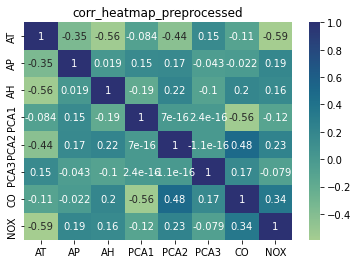

In [15]:
df_preprocessed_corr=df_preprocessed.corr()
sns.heatmap(df_preprocessed_corr,annot=True,cmap="crest")
plt.title("corr_heatmap_preprocessed")
plt.savefig("./corr_heatmap_preprocessed.png")

# 2.模型拟合
主要分为多元线性回归和岭回归两种模型选择

In [16]:
#定义一个类来完成两种模型的数据分析
class model_fit():
    def __init__(self,data,y_label):
        #若输入的y_label不是data中的某个列名，则引发异常
        try:
            tmp = data[y_label]
        #若出现以上异常则输出如下语句
        except KeyError:
            print("y_lable must be a column name of data!")
        self.data = data
        self.x = self.data.drop(["CO","NOX"],axis = 1,inplace = False)
        #y_label表示响应变量的指标名称
        self.y = data[y_label]
        
        
    ##多元线性回归部分
    ###用OLS拟合多元线性回归模型
    def linear_regression(self):
        #给协变量加上一个常数项
        x = sm.add_constant(self.x)
        y = self.y
        model = sm.OLS(y,x)
        return(model)
    ###获取多元线性回归模型的result
    def linear_result(self):
        return(self.linear_regression().fit())
    
    
    ##岭回归部分
    ###给定岭回归参数的情况下拟合岭回归模型
    def ridge_regression(self,ridge_alpha):
        #若岭参数不为正数则引发异常
        try:
            #设置一个对数函数来判断alpha是否为正数
            tmp = math.log10(ridge_alpha)
            #若出现以上异常则输出如下语句
        except ValueError:
            print("ridge_alpha must be positive!")
        model = Ridge(alpha = ridge_alpha)
        return(model)
    ###获取岭回归模型的结果
    def ridge_result(self,ridge_alpha):
        return(self.ridge_regression(ridge_alpha).fit(self.x,self.y))
    ###将数据集分成10份做交叉验证，求出平均交叉验证分数(这里scoring="r2"是指用R-squared作为交叉验证分数)
    def score(self,ridge_alpha):
        score = cross_val_score(self.ridge_regression(ridge_alpha),self.x,self.y,cv=10,scoring = "r2").mean()
        return(score)

## 2.1.多元线性回归

### 2.1.1.响应变量为CO

In [17]:
#多元线性回归
##CO
###实例化model_fit类
reg_CO = model_fit(data = df_preprocessed,y_label = "CO")
result = reg_CO.linear_result()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     CO   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     4961.
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        21:22:56   Log-Likelihood:                -22046.
No. Observations:               22191   AIC:                         4.411e+04
Df Residuals:                   22184   BIC:                         4.416e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.398e-16      0.004      1e-13      1.000      -0.009       0.009
AT             0.0617      0.006      9.587      0.000       0.049       0.074
AP             0.0077      0.005      1.596      0.111      -0.002       0.017
AH             0.0387      0.006      6.834      0.000       0.028       0.050
PCA1          -0.2491      0.002   -118.903      0.000      -0.253      -0.245
PCA2           0.6177      0.006    101.284      0.000       0.606       0.630
PCA3           0.2325      0.006     36.324      0.000       0.220       0.245
==============================================================================
Omnibus:                    31384.164   Durbin-Watson:                   0.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20201926.426
Skew:                           8.096   Prob(JB):                         0.00
Kurtosis:                     149.924   Cond. No.                         4.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2.1.2.响应变量为NOX

In [18]:
#多元线性回归
##NOX
###实例化model_fit类
reg_NOX = model_fit(data = df_preprocessed,y_label = "NOX")
result = reg_NOX.linear_result()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    NOX   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     3068.
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        21:22:56   Log-Likelihood:                -24783.
No. Observations:               22191   AIC:                         4.958e+04
Df Residuals:                   22184   BIC:                         4.964e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.525e-16      0.005   -7.1e-14      1.000      -0.010       0.010
AT            -0.8603      0.007   -118.217      0.000      -0.875      -0.846
AP            -0.0564      0.005    -10.306      0.000      -0.067      -0.046
AH            -0.3552      0.006    -55.382      0.000      -0.368      -0.343
PCA1          -0.1133      0.002    -47.780      0.000      -0.118      -0.109
PCA2          -0.0793      0.007    -11.488      0.000      -0.093      -0.066
PCA3           0.0193      0.007      2.671      0.008       0.005       0.034
==============================================================================
Omnibus:                     4712.155   Durbin-Watson:                   0.421
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16694.211
Skew:                           1.047   Prob(JB):                         0.00
Kurtosis:                       6.697   Cond. No.                         4.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2.2.岭回归

岭回归和PCA都是适用于多重共线性的情况，所以这里岭回归选择用未经PCA处理之前的数据df_scaled来拟合模型

### 2.2.1.响应变量为CO

In [19]:
#这里选择用未经PCA处理之前的数据来拟合模型
reg_CO_ridge = model_fit(data = df_scaled,y_label = "CO")
#岭参数选择
alpha_range = np.logspace(-4,4,1000)#岭回归参数的取值范围
cv_score = []#交叉验证分数

#将每一个岭参数的交叉验证分数放入cv_score列表中
for a in alpha_range:
    cv_score.append(reg_CO_ridge.score(ridge_alpha = a))

best_alpha_CO = alpha_range[cv_score.index(max(cv_score))]#找到最佳的alpha
print("best_alpha is", best_alpha_CO)
print("best_mean_CV_score is", max(cv_score))

best_alpha is 1671.9497597319883
best_mean_CV_score is 0.38519294852846103


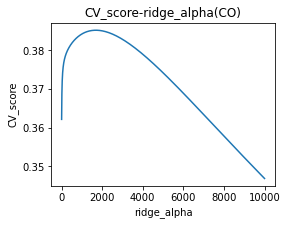

In [20]:
#画出交叉验证分数-岭参数的关系图
plt.figure(figsize = (4,3))
plt.xlabel('ridge_alpha')
plt.ylabel("CV_score")
plt.title("CV_score-ridge_alpha(CO)")
plt.plot(alpha_range, cv_score)
plt.savefig("./ridge_CO.jpg")

In [21]:
#模型的系数以及截距项
print(reg_CO_ridge.ridge_result(best_alpha_CO).coef_)
reg_CO_ridge.ridge_result(best_alpha_CO).intercept_

[ 0.02184812  0.0044699   0.03169053 -0.02851421 -0.102939   -0.42392459
 -0.37811683 -0.2244173  -0.11066731]


2.8895891653066293e-15

### 2.2.2.响应变量为NOX

In [22]:
#这里选择用未经PCA处理之前的数据来拟合模型
reg_NOX_ridge = model_fit(data = df_scaled,y_label = "NOX")
#岭参数选择
alpha_range = np.logspace(-1,2,1000)#岭回归参数的取值范围
cv_score = []#交叉验证分数

#将每一个岭参数的交叉验证分数放入cv_score列表中
for a in alpha_range:
    cv_score.append(reg_NOX_ridge.score(ridge_alpha = a))

best_alpha_NOX = alpha_range[cv_score.index(max(cv_score))]#找到最佳的alpha
print("best_alpha is", best_alpha_NOX)
print("best_mean_CV_score is", max(cv_score))

best_alpha is 11.969557023590427
best_mean_CV_score is 0.12346738437500818


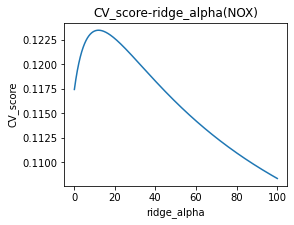

In [23]:
#画出交叉验证分数-岭参数的关系图
plt.figure(figsize = (4,3))
plt.xlabel('ridge_alpha')
plt.ylabel("CV_score")
plt.title("CV_score-ridge_alpha(NOX)")
plt.plot(alpha_range, cv_score)
plt.savefig("./ridge_NOX.jpg")

In [24]:
#模型的系数以及截距项
print(reg_NOX_ridge.ridge_result(best_alpha_NOX).coef_)
reg_NOX_ridge.ridge_result(best_alpha_NOX).intercept_

[-1.24818505 -0.10043329 -0.36091644 -0.01477388  0.4721321   0.96268036
 -0.19501873 -2.4713413   0.70069925]


-1.1160110391124894e-14

# 3.在验证集上比较模型的预测误差

## 3.1.验证集数据预处理

In [25]:
#将验证集的数据做中心化和标准化
df_validation_scaled = z_scaler.fit_transform(df_validation)
df_validation_scaled = pd.DataFrame(df_validation_scaled)
df_validation_scaled.columns = df_validation.columns

#计算验证集的三个主成分
pca_validation = pca3.fit_transform(df_validation_scaled[['AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP']])
pca_validation = pd.DataFrame(pca_validation, columns=['PCA1', 'PCA2', 'PCA3'])
#合并成经过scaled和preprocessed的验证集
df_validation_preprocessed =  pd.concat([df_validation_scaled[["AT","AP","AH"]],pca_validation,df_validation_scaled[["CO","NOX"]]],axis=1)

In [26]:
#将所有预处理之后的数据保存成csv文件
data_preprocessed = pd.concat([df_preprocessed,df_validation_preprocessed],ignore_index = True,axis = 0)
data_preprocessed.to_csv("data_preprocessed.csv")

## 3.2.计算各模型的预测误差

In [27]:
#定义一个predict_error类,用于计算预测误差
class predict_error():
    def __init__(self,model_result,data,y_label):
        #若输入的y_label不是data中的某个列名，则引发异常
        try:
            tmp = data[y_label]
        #若出现以上异常则输出如下语句
        except KeyError:
            print("y_lable must be a column name of data!")
        self.result = model_result
        self.data = data
        self.x = self.data.drop(["CO","NOX"],axis = 1,inplace = False)
        #y_label是"CO"或者"NOX"
        self.y = self.data[y_label]
       
    #多元线性回归部分
    ##多元线性回归模型的预测值
    def linear_predict(self):
        y_predict = self.result.predict(sm.add_constant(self.x))
        return(y_predict)
    ##用绝对误差的均值来计算预测误差
    def linear_predict_error(self):
        return(mean_absolute_error(self.y, self.linear_predict()))
    
    #岭回归部分
    ##岭回归模型的预测值
    def ridge_predict(self):
        y_predict = self.result.predict(self.x)
        return(y_predict)
    ##用绝对误差的均值来计算预测误差
    def ridge_predict_error(self):
        return(mean_absolute_error(self.y, self.ridge_predict()))

## 3.3.计算结果

### 3.3.1.多元线性回归(CO)

In [28]:
#实例化predict_error类
linear_error_CO = predict_error(reg_CO.linear_result(),data = df_validation_preprocessed,y_label = "CO")
linear_error_CO.linear_predict_error()

0.3943245742671696

### 3.3.2.多元线性回归(NOX)

In [29]:
#实例化predict_error类
linear_error_NOX = predict_error(reg_NOX.linear_result(),data = df_validation_preprocessed,y_label = "NOX")
linear_error_NOX.linear_predict_error()

0.5378170243746104

### 3.3.3.岭回归(CO)

In [30]:
#实例化predict_error类，用之前交叉验证选择的best_alpha_CO做岭参数
#注意这里的data是未经pca处理的
ridge_error_CO = predict_error(reg_CO_ridge.ridge_result(best_alpha_CO),data = df_validation_scaled,y_label = "CO")
ridge_error_CO.ridge_predict_error()

0.40931793295931307

### 3.3.4.岭回归(NOX)

In [31]:
#实例化predict_error类，用之前交叉验证选择的best_alpha_NOX做岭参数
#注意这里的data是未经pca处理的
ridge_error_NOX = predict_error(reg_NOX_ridge.ridge_result(best_alpha_NOX),data = df_validation_scaled,y_label = "NOX")
ridge_error_NOX.ridge_predict_error()

0.5718432771895733